#### Import Statements

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from matplotlib.colors import Normalize

## 1. Dataset Selection

The dataset is located here: [Breast Cancer Dataset](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)

With this dataset, I am going to determine what features are important for diagnosing a breast mass as malignant or benign. I am going to do this though a classification task, making a decision tree. Then I am going to use an unsupervised technique, clustering. I am going to check if the important features that I found through the decision tree match with my results from clustering.

Data Features:

The features were computed from digitized images of breast masses. The features are composed of characteristics of cell nuclei. There are 3 different grades of cell nuclei. The different grades are distinguished by the number at the end the variable name (ex: radius*1* refers to radius of cell nucleus of grade 1).

There is an identifier variable, ID number and a target variable, Diagnosis. The Diagnosis variable is coded as follows M = malignant, B = benign.

For each cell nucleus (1-3), there are 10 features:

1. radius (mean of distances from center to points on the perimeter)
2. texture (standard deviation of gray-scale values)
3. perimeter
4. area
5. smoothness (local variation in radius lengths)
6. compactness (perimeter^2 / area - 1.0)
7. concavity (severity of concave portions of the contour)
8. concave points (number of concave portions of the contour)
9. symmetry 
10. fractal dimension ("coastline approximation" - 1)

A score is given from 1 to 3, based on what the nucleus of the cancer cells looks like compared to normal cells. In nuclear grade 1, the nucleus of the cells looks more like normal cells, while in nuclear grade 3, it looks the least like normal cells.

## 2. Data Preprocessing and Exploratory Data Analysis (EDA)

In [3]:
columns = ['ID','Diagnosis','radius1','texture1','perimeter1','area1','smoothness1','compactness1','concavity1','concave_points1','symmetry1','fractal_dimension1','radius2','texture2','perimeter2','area2','smoothness2','compactness2','concavity2','concave_points2','symmetry2','fractal_dimension2','radius3','texture3','perimeter3','area3','smoothness3','compactness3','concavity3','concave_points3','symmetry3','fractal_dimension3']
df = pd.read_csv('wdbc.data', header=None, names=columns)

In [5]:
df

,ID,Diagnosis,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [3]:
# proportion of data that is malignant
total_obs = df['ID'].count()
malignant = (df['Diagnosis'] == 'M').sum()
proportion = malignant / total_obs
print(proportion)

0.37258347978910367


I checked to make sure a decent proportion of the data contains a diagnosis of malignant. Given that a decent proportion of the data is malignant, I do not think that stratified kfold is necessary.

In [4]:
# Make target variable a dummy variable
df['Diagnosis'] = df['Diagnosis'].replace({'M': 1, 'B': 0})

In [5]:
# Diagnosis as target variable & everything else as features
X = df.drop(['Diagnosis','ID'], axis=1)
y = df['Diagnosis']

In [6]:
# Scale Variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Its important to scale our variables so that variables with high means and variances don't drive the clustering or decision trees.

## 3. Feature Engineering and Selection

Dimension reduction techniques such as Principle Components Analysis is not necessary for this dataset.

## 4. Machine Learning Techniques

First, I am going to construct a decision tree with its default arguments. Depending on the structure of the tree, I might have to find the best hyperparameters through cross validation to make the structure less complex.

Making an interpretable decision tree will allow me to identify the variables of importance in predicting the diagnosis.

#### Decision Trees

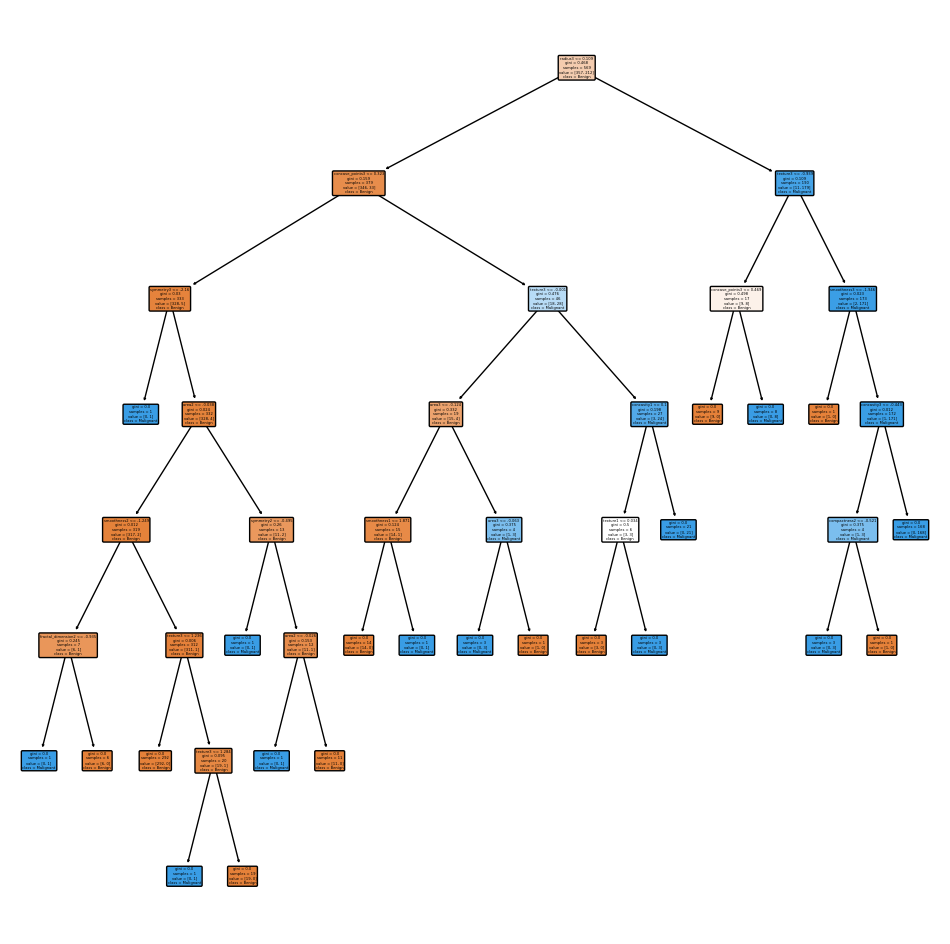

In [7]:
# Create and fit the decision tree
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_scaled,y)

# Visualize the tree
plt.figure(figsize=(12, 12))
plot_tree(dt, filled=True, feature_names=X.columns, class_names=["Benign", "Malignant"], rounded=True)
plt.show()

This decision tree was built using the default arguments. Given the structure is far too complex, this decision tree likely overfits the data. It also is impossible to interpret because we are unable to read the nodes. This doesn't allow us to narrow down what the important variables are to determine whether a breast mass is malignant or benign. In order to make this tree less complex, I am going to use cross validation to find the best hyperparameters. I am going to search separately for two different hyperparameters, the max depth and alpha. Finding the optimal hyperparameter will prune the tree and make it less complex.

In [7]:
# Find best depth for Decision Tree
dt = DecisionTreeClassifier(random_state=10)

# depth range to search over
param_grid = {'max_depth': list(range(1, 5))}

# searching
grid_search = GridSearchCV(dt, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_scaled, y)

# best depth & its accuracy
best_max_depth = grid_search.best_params_['max_depth']
best_score = grid_search.best_score_


print(f"Best max_depth: {best_max_depth:.4f}")
print(f"Best mean accuracy: {best_score:.4f}")

Best max_depth: 2.0000
Best mean accuracy: 0.9192


Using cross validation, the optimal depth for the decision tree is 2. That means the max amount of splits is going to be 2. The accuracy of this decision tree is 92%.

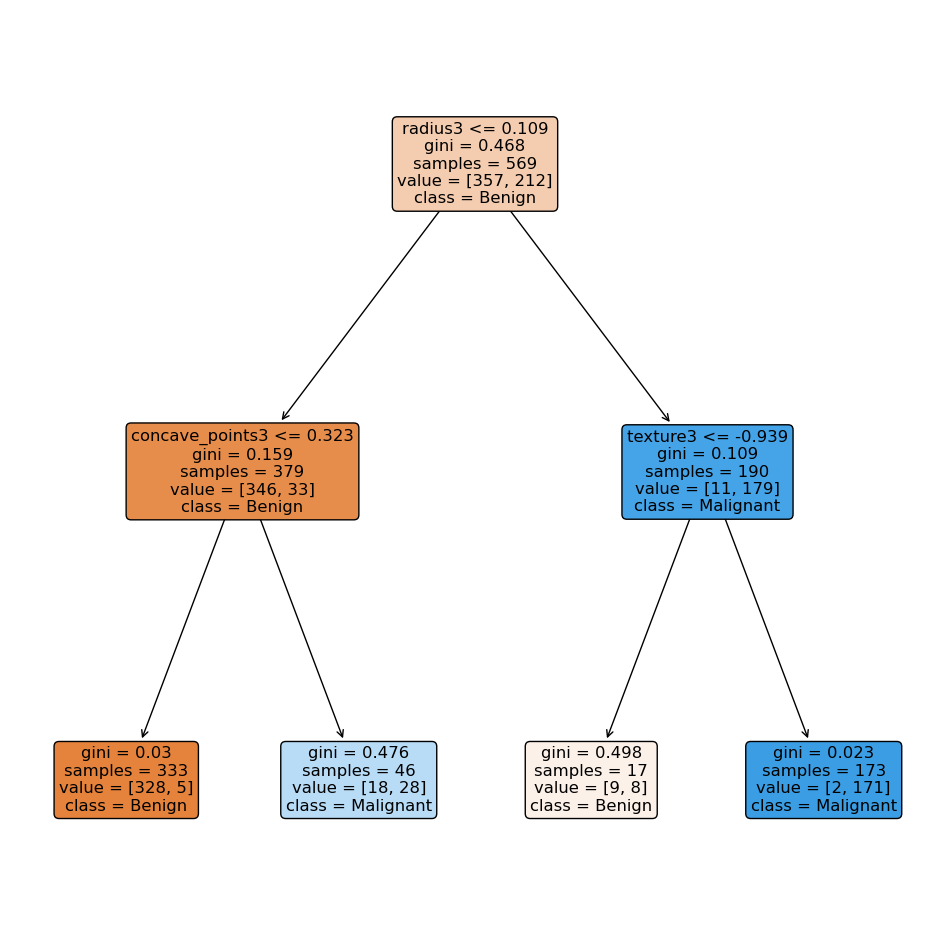

In [8]:
# Decision Tree with Best Depth
dt = DecisionTreeClassifier(max_depth=best_max_depth, random_state=10)
dt.fit(X_scaled, y)

# Visualize the tree
plt.figure(figsize=(12, 12))
plot_tree(dt, filled=True, feature_names=X.columns, class_names=["Benign", "Malignant"], rounded=True)
plt.show()

Based on this decision tree, we are able to make some interpretations. Given that the initial splitting criterion is the radius of the grade 3 cell nucleus, it tells us that radius is a very important feature. The inital splitting criterion that the decision uses is whether the radius of the cell nucleus is less than or equal to 0.109 units. This suggests that the radius is a critical feature in predicting the diagnosis of the mass. Cells with a smaller radius are benign. The next splits are grade 3 concave points and texture. So if the radius is less than or equal to -0.939 units and the concave points are less than or equal to 0.136, then the mass is likely benign. This suggests that cell nuclei with smaller radius and small number of concave points are likely to be benign. On the flip side, if the radius is greater than 0.109 units, then we look at the texture of the cell nucleus to predict the diagnosis. If the texture is less than or equal to 0.323 units, then the mass is likely benign. If the texture is greater than -0.939 units, then the mass is likely malignant. This suggests that masses with a bigger radius and lots of texture are likely malignant. 

(Side note: I refer to units because the features are scaled here.)

The nodes with very low Gini impurities indicate high confidence in classification decisions. This means that the paths leading to these nodes should be good predictors of the mass diagnosis. Nodes with low Gini impurities come from the path of low radius to low concave points to benign and the path of big radius to lots of texture to malignant.

Nodes with high Gini impurities suggest uncertainty.

Overall, this highlights the importance of radius, concave points, and texture of the cell nucleus in predicting the diagnosis of breast masses.

In [10]:
# Find best alpha for Decision Tree
dt = DecisionTreeClassifier(random_state=10)

# alpha range to search
param_grid = {'ccp_alpha': np.linspace(0, 0.05, 50)}

# searching
grid_search = GridSearchCV(dt, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_scaled, y)

# best alpha & its accuracy
best_ccp_alpha = grid_search.best_params_['ccp_alpha']
best_score = grid_search.best_score_

print(f"Best ccp_alpha: {best_ccp_alpha:.4f}")
print(f"Best mean accuracy: {best_score:.4f}")

Best ccp_alpha: 0.0184
Best mean accuracy: 0.9280


Using cross validation, I found that the optimal alpha is 0.0184. The accuracy of this decision tree is 93%.

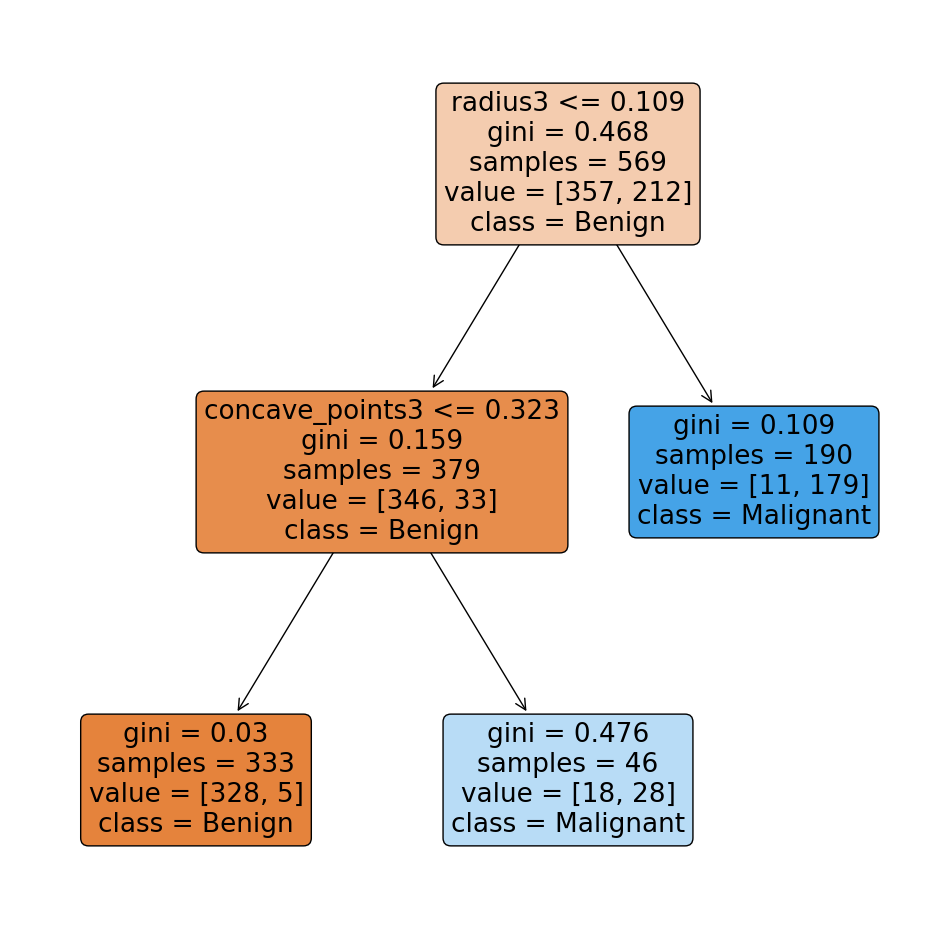

In [11]:
# Decision Tree with best alpha
# Visualize tree using hyperparameters
dt = DecisionTreeClassifier(ccp_alpha=best_ccp_alpha,random_state=10)
dt.fit(X_scaled, y)

# Visualize the tree
plt.figure(figsize=(12, 12))
plot_tree(dt, filled=True, feature_names=X.columns, class_names=["Benign", "Malignant"], rounded=True)
plt.show()

Both splitting criteria deal with features grade 3 cell nuclei, radius and concave points.

From both decision trees, we can see that the most important features are the radius of the cell nucleus and the number of concave points.

Based on this decision tree, we can understand the data better. The initial splitting criterion is again radius (same splitting point as above dt- 0.109). If the radius is smaller and there are few concave points (same splitting point as above dt - 0.323), then the mass is likely to be benign. If the radius is smaller but there a more concave points, then the mass is likely to be malignant. If the radius is bigger, than the mass is likely to be malignant. The path of small radius to low concave points to benign has low gini impurity. This indicates high confidence in this path. 

Connecting this to the other tree, both trees emphasize that radius and concave points are important features for predicting the diagnosis of breast masses.

#### Clustering

Now, I am going to use K-means clustering to verify that these features, radius and concave points of grade 3 cell nuclei, are significant.

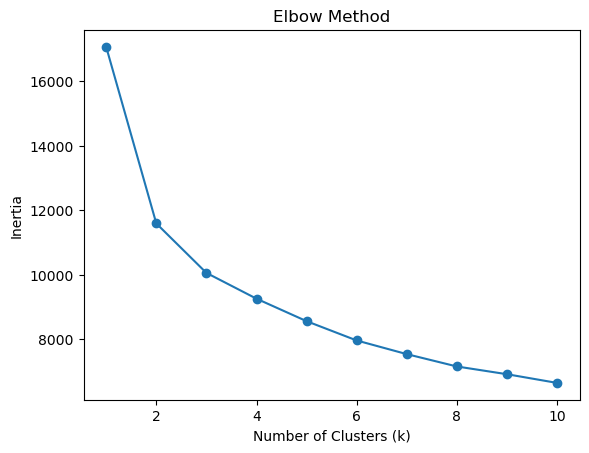

In [6]:
# Find optimal number of clusters using the elbow method
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

Optimal number of clusters seems to be `k = 3`.  

The elbow method plots the number of clusters against the inertia to see when the inertia stops visually decreasing by a lot (meaning that more clusters doesn't decrease the within cluster variance by that much). Optimal number of clusters is 3 because it has a steep slope there and then the slope flattens out after (i.e., the inertia doesn't decrease by much more). 

Based on the results of the decision trees above, I am going to cluster the features with the grade 3 cell nucleus (all the features with "3" at the end). From the decision trees, I saw these features with grade 3 cells are good predictors for diagnosis since they were the splitting criteria. Also this grade of cell is abnormal so it is important to focus on those anyways.

In [5]:
# filtering X for 3rd cell nucleus 
X = df.drop(['Diagnosis','ID'], axis=1)
X_3 = X.loc[:, [col for col in X.columns if col.endswith('3')]]
y = df['Diagnosis']

# scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_3)

X_scaled_df = pd.DataFrame(X_scaled, columns=X_3.columns)
X_scaled_df.index = df.index
diagnosis_id_df = df[['Diagnosis', 'ID']]

# filtered df with grade 3 features and diagnosis and ID
df_filtered = pd.concat([diagnosis_id_df, X_scaled_df], axis=1)

In [6]:
k = 3 # based on elbow plot

kmeans = KMeans(n_clusters=k, random_state=10)
kmeans.fit(X_scaled)
labels_kmeans = kmeans.labels_

df_filtered['Cluster_KMeans'] = labels_kmeans

Now, I am plotting these clusters on a scatterplot. Using a scatterplot makes it easy to interpret the clusters.

So I performed clustering on all the grade 3 cell nuclei features and now I'm creating a scatterplot using the two distinct features, radius and concave points. If this plot has distinct clusters, then it could indicate feature importance.

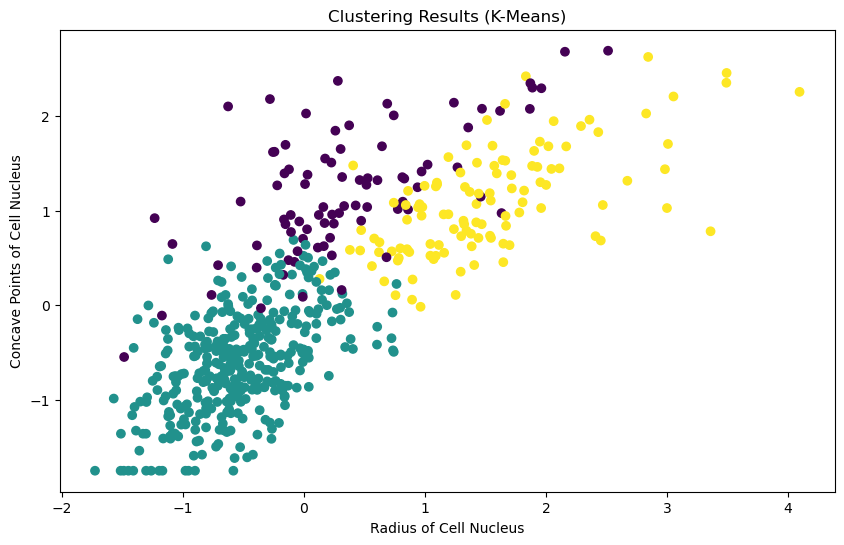

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['radius3'], df_filtered['concave_points3'], c=df_filtered['Cluster_KMeans'], cmap='viridis') 
plt.xlabel('Radius of Cell Nucleus')
plt.ylabel('Concave Points of Cell Nucleus')
plt.title('Clustering Results (K-Means)')
plt.show()

For these two features, concave points and radius of grade 3 cell nuclei, there are distinct clusters. Since clusters are distinct when plotted against these two features indicates that these features are significant in terms of explaining the behavior in this dataset. It means that these features have key information that differentiates between the clusters. So this scatterplot supports our findings from the decision trees.

For this next scatter plot, I am going to add an argument to differentiate which data points are malignant or benign. I will look at this to see if it matches the results from the decision tree. Recall, from the decision tree I found that big radius and high number of concave points tends to lead to malignant diagnosis.

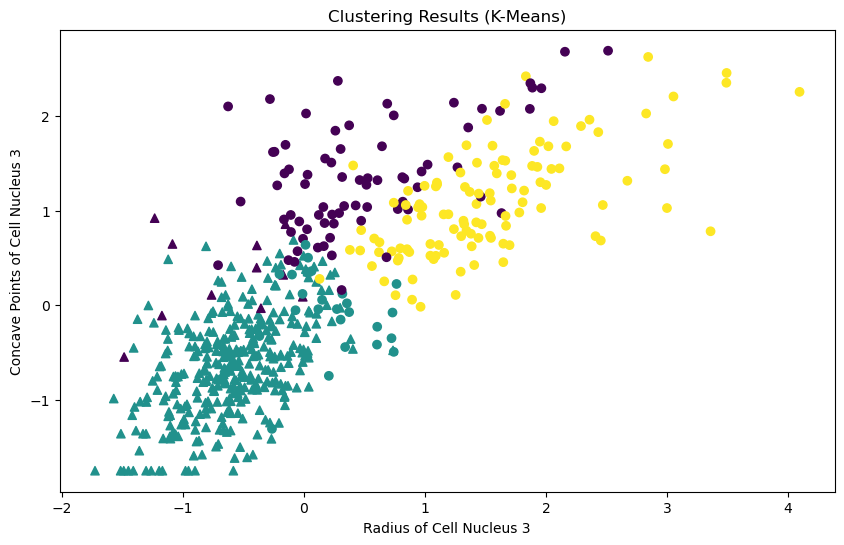

In [8]:
# scatterplot with shape for diagnosis
shape = {1: 'o', 0: '^'}  # circles for malignant, triangles for benign

plt.figure(figsize=(10, 6))
norm = Normalize(vmin=df_filtered['Cluster_KMeans'].min(), vmax=df_filtered['Cluster_KMeans'].max()) # to make sure the same colors are used as above visual

# to add shape arg for diagnosis
for diagnosis, group in df_filtered.groupby('Diagnosis'):
    plt.scatter(group['radius3'], group['concave_points3'], 
                c=group['Cluster_KMeans'], cmap='viridis',norm=norm, 
                marker=shape[diagnosis], label=f'Diagnosis: {diagnosis}')
    
plt.xlabel('Radius of Cell Nucleus 3')
plt.ylabel('Concave Points of Cell Nucleus 3')
plt.title('Clustering Results (K-Means)')
plt.show()

The triangle shaped points are the benign masses and the circle shaped points are the malignant masses. 

This scatterplot also supports my findings from the decision tree. 

Cell nuclei with a larger radius are likely to be malignant breast masses. Cell nuclei with a higher number of concave points are malignant breast masses. We can see by all the triangles in the bottom left corner that cell nuclei with both a low radius and small number of concave points are mostly benign masses.

## 5. Model Interpretation and Insights

The important features for diagnosing a breast mass as malignant or benign is the radius and number of concave points of grade 3 cell nuclei. This finding is supported by both (cross-validated) decision trees and the clusters. More in-depth interpretations are provided under the models themselves.

I also noted that the texture of grade 1 cells also appeared as a splitting criteria in the decision tree with optimal depth. It could be interesting to look at each grade of cell nuclei by itself. This is something I could explore in the future. 

## 6. Documentation and Presentation

Documentation provided in Markdown cells throughout this notebook.

[Link to my Presentation](./DS380FinalSlides.pdf)

(I submitted my Presentation on BlackBoard)